In [1]:
from os import walk
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
#sns.set()

#path to your input result folder
result_path = "../hardware/results"
#path to the output csv
csv_path= "./results.csv"


def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter


In [2]:
print("Processing files at", result_path)

todo, done = 0, 0
for (dirpath, dirnames, filenames) in walk(result_path):
    for filename in filenames:
        if filename == "transcript":
            todo+=1

configs = []
tot_df = pd.DataFrame()
for (dirpath, dirnames, filenames) in walk(result_path):
    num_cores = -1
    num_data = -1
    num_local_data = -1
    max_val = -1
    seed = -1
            
    for filename in filenames:
        if filename != "transcript":
            continue
        p = re.compile("[0-9]+")
        # Get parameters from the directory name first
        num_cores, num_data, max_val, seed = dirpath.split('/')[-2].split('_')[-4:]
        num_cores, num_data, max_val, seed = int(num_cores), int(num_data), int(max_val), int(seed)
        nul_local_data = int(num_data / num_cores)
        # Override them based on transcript if any
        with open(dirpath+"/"+filename, "r") as fp:
            for line in fp.readlines():
                if "Benchmark" not in line:
                    continue
                p = re.compile("[0-9]+")
                print([a.group() for a in p.finditer(line)])
                num_cores, num_data, num_local_data = [a.group() for a in p.finditer(line)]
                num_cores, num_data, num_local_data = int(num_cores), int(num_data), int(num_local_data)
                if "ERROR" in line:
                    print("ERROR")
                    assert(0)

        # Read CSV
        print("\r{}/{}".format(done, todo), end="")
        done += 1
        df = pd.read_csv(dirpath+"/results.csv", index_col=0)
        df["num_cores"] = int(num_cores)
        df["num_data"] = int(num_data)
        df["num_local_data"] = int(num_local_data)
        df["max_val"] = int(max_val)
        df["seed"] = int(seed)
        # Concat everyone
        configs.append([num_cores, num_data, num_local_data])
        tot_df = pd.concat([tot_df, df], axis=0, join="outer", ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, copy=True)
print("")
# Drop nans
to_drop = tot_df.columns[tot_df.isnull().any()]
for nan_col in to_drop:
    assert(not nan_col in ['cycles', 'num_data', 'num_cores'])
    tot_df = tot_df.drop(nan_col, axis=1)

# Drop strings
tot_df = tot_df.select_dtypes(exclude=['object'])

tot_df.to_csv(csv_path)
print("Results exported to", csv_path)

Processing files at ../hardware/results
174/175
Results exported to ./results.csv


In [3]:
tot_df = pd.read_csv(csv_path)
print(tot_df.shape)
print(tot_df.head())

(29172, 16)
   core  section  start    end  cycles  snitch_loads  snitch_stores  \
0     0        0  18928  22228    3301           512            512   
1     0        1  22230  28305    6076           590            102   
2     0        2  28307  28307       1             0              0   
3     1        0  19828  31312   11485           279            283   
4     1        1  31314  33755    2442           315             49   

   snitch_avg_load_latency  snitch_occupancy  total_ipc  snitch_issues  \
0                10.253906          0.428658   0.428658           1415   
1                 4.149153          0.528802   0.528802           3213   
2                 0.000000          1.000000   1.000000              1   
3                 9.581227          0.125990   0.125990           1447   
4                 1.412698          0.700246   0.700246           1710   

   num_cores  num_data  num_local_data  max_val        seed  
0          1         2              -1       32  16713

In [22]:
# iddx of the CI of the median with 95%
def ci_idx(n):
    return [int((n-1.96*np.sqrt(n))/2), int(np.ceil(1+(n+1.96*np.sqrt(n))/2))]

# return (ci_low, median, ci_high) for a list of values
def median_and_ci(data):
    n = len(data)
    a, b = ci_idx(n)
    data_sorted = sorted(data)
    return data_sorted[a], data_sorted[int(n/2)], data_sorted[min(b, n-1)]

def get_median(data):
    return median_and_ci(data)[1]
def get_ci(data):
    a, b, c = median_and_ci(data)
    return a, c

def get_ideal_speedup(a, b, n=100):
    X = np.linspace(a, b, num=n)
    return X, X

Tot_df : (29172, 16)
Experiment : (9243, 16)
( 1 , 7 ) : ( 0.155945 , 0.156632 , 0.158513 )
( 2 , 7 ) : ( 0.078999 , 0.079387 , 0.080373 )
( 4 , 7 ) : ( 0.041147 , 0.041306 , 0.041857 )
( 8 , 7 ) : ( 0.021736 , 0.02226 , 0.02246 )
( 16 , 6 ) : ( 0.012394 , 0.012757 , 0.013323 )
( 32 , 6 ) : ( 0.007619 , 0.008314 , 0.008457 )
( 64 , 6 ) : ( 0.005015 , 0.005371 , 0.005802 )
( 128 , 6 ) : ( 0.004113 , 0.004396 , 0.004774 )
( 256 , 6 ) : ( 0.00358 , 0.003961 , 0.004107 )


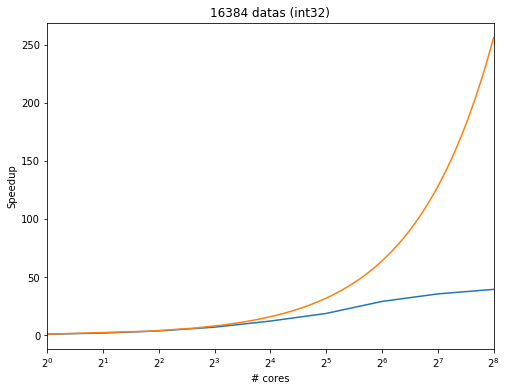

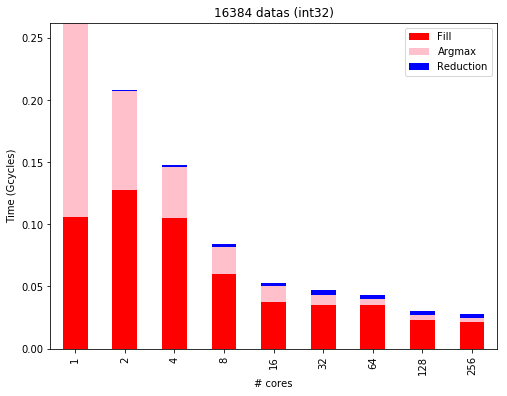

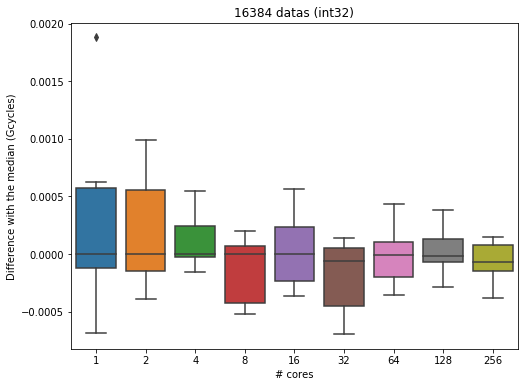

In [50]:
print("Tot_df :", tot_df.shape)

colors = [(64, "green")]


#
# Strong scaling with confidence intervals
#

for num_data, color in colors: #tot_df['num_data'].unique():
    experiment_df = tot_df.loc[tot_df['num_data'] == num_data]
    print("Experiment :", experiment_df.shape)
    Y1, Y1_low, Y1_high = [], [], []
    Y1_fill, Y1_argmax, Y1_reduction = [], [], []
    num_cores_arr = [1, 2, 4, 8, 16, 32, 64, 128, 256]
    all_cores = []
    all_tot = []
    for num_cores in num_cores_arr:
        res_fill = []
        res_argmax = []
        res_reduction = []
        res_tot = []
        maxs = []
        for seed in experiment_df['seed'].unique():
            mask = (experiment_df['seed'] == seed) & (experiment_df['num_cores'] == num_cores)
            masked = experiment_df[mask]
            if masked.empty:
                continue
            res_fill.append(      masked.loc[masked['section'] == 0]['cycles'].max() / 1000000 )
            res_argmax.append(    masked.loc[masked['section'] == 1]['cycles'].max() / 1000000 )
            res_reduction.append( masked.loc[masked['section'] == 2]['cycles'].max() / 1000000 )
            # All does not count fill section
            res_tot.append(       masked[masked['section']!=0].groupby(['core']).cycles.sum().max() / 1000000)
            all_cores.append(     num_cores)
            all_tot.append(       masked[masked['section']!=0].groupby(['core']).cycles.sum().max() / 1000000)
        if len(res_tot) == 0:
            continue
        lo, median, hi = median_and_ci(res_tot)
        Y1.append(median)
        Y1_low.append(lo)
        Y1_high.append(hi)
        Y1_fill.append(get_median(res_fill))
        Y1_argmax.append(get_median(res_argmax))
        Y1_reduction.append(get_median(res_reduction))
        print("(", num_cores, ",", len(res_tot), ")", end=" : ")
        print("(", lo, ",", median, ",", hi, ")")
    
    Y1 = np.array(Y1)
    all_cores = np.array(all_cores)
    all_tot = np.array(all_tot)
    
    #plot_errorbars()
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xscale('log', basex=2)
    ax.set_xlim(1, 256)
    #sns.pointplot(num_cores_arr, Y1[0]/Y1, errorbar=get_ci, join=False, ax=ax)
    #sns.pointplot(num_cores_arr, 2*Y1[0]/Y1, errorbar=get_ci, join=False, ax=ax)
    plt.plot(num_cores_arr, Y1[0]/Y1)
    plt.plot(get_ideal_speedup(1, 256)[0], get_ideal_speedup(1, 256)[1])
    plt.title(str(num_data * 256) + " datas (int32)")
    plt.xlabel("# cores")
    plt.ylabel("Speedup")
    
    plt.figure(figsize=(8, 6), dpi=80)
    plot_df = pd.DataFrame({'Cores': num_cores_arr, 'Fill': Y1_fill, 'Argmax': Y1_argmax, 'Reduction': Y1_reduction}, \
                           columns = ['Cores', 'Fill', 'Argmax', 'Reduction'])
    plot_df = plot_df.set_index('Cores')
    plot_df.plot(kind='bar', stacked=True, color=['red', 'pink', 'blue'], ax=plt.gca())
    plt.title(str(num_data * 256) + " datas (int32)")
    plt.xlabel("# cores")
    plt.ylabel("Time (Gcycles)")
    
    plt.figure(figsize=(8, 6), dpi=80)
    filter_box = all_cores == 1
    
    # Remove median
    for num_cores in num_cores_arr:
        idx = np.where(all_cores == num_cores)
        median = get_median(all_tot[idx])
        all_tot[idx] -= median

    plot_df = pd.DataFrame({'Cores': all_cores,
                            'Total': all_tot}, \
                           columns = ['Cores', 'Total'])
    sns.boxplot(data=plot_df, x="Cores", y="Total")
    plt.title(str(num_data * 256) + " datas (int32)")
    plt.xlabel("# cores")
    plt.ylabel("Difference with the median (Gcycles)")
    